In [2]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: 'strucchange'


The following object is masked from 'package:stringr':

    boundary




Accessing CANSIM NDM vectors from Statistics Canada



# A tibble: 100 × 4
   quarter VALUE cpi_previous_quarter delta_cpi
     <dbl> <dbl>                <dbl>     <dbl>
 1   2000.  95.7                 NA     NA     
 2   2000.  96.7                 95.7    1.07  
 3   2001.  96.9                 96.7    0.241 
 4   2001.  98.2                 96.9    1.30  
 5   2001.  98.2                 98.2    0.0339
 6   2001.  97.7                 98.2   -0.510 
 7   2002.  98.4                 97.7    0.714 
 8   2002.  99.5                 98.4    1.08  
 9   2002. 101.                  99.5    1.10  
10   2002. 101.                 101.     0.858 
# ℹ 90 more rows


Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


ERROR: Error: object 'cpi_quarterly_adj' not found


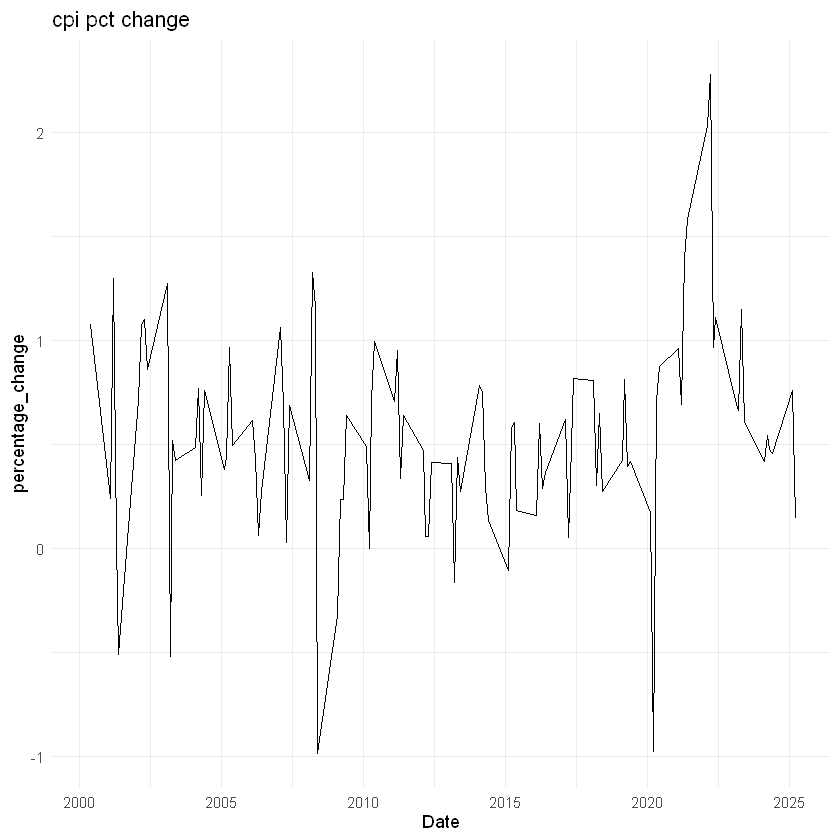

In [ ]:
cpi_vec <- get_cansim_vector_for_latest_periods("v41690914", periods = 300)

cpi_vec_adj <- cpi_vec|>
select("Date", "VALUE")|>
 mutate(
    # Get the CPI value from 12 months ago
    cpi_previous_year = lag(VALUE, 12),
    # Calculate the percentage change
    cpi_change = ((VALUE  / cpi_previous_year) - 1) * 100
  )

cpi_quarterly_stationary <- cpi_vec |>
  select(Date, VALUE) |>
  mutate(quarter = quarter(Date, with_year = TRUE)) |>
  group_by(quarter) |>
  summarise(VALUE = mean(VALUE, na.rm = TRUE)) |>
  ungroup() |>
  mutate(
    cpi_previous_quarter = lag(VALUE, 1),
    delta_cpi = (log(VALUE) - log(cpi_previous_quarter)) * 100
  )|>

print(cpi_quarterly_stationary)

ggplot(cpi_quarterly_stationary, aes(x = quarter, y = delta_cpi)) +
  geom_line() +
  labs(
    title = "cpi pct change",
    x = "Date",
    y = "percentage_change",
  ) +
  theme_minimal()


adf_result <- adf.test(na.omit(cpi_quarterly_adj$cpi_change))

# Print the results
print(adf_result)

In [9]:
ts_data <- na.omit(cpi_quarterly_stationary$delta_cpi)


	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = y ~ x)

Breakpoints at observation number:
                      
m = 1               79
m = 2      31       79
m = 3      32 47    79
m = 4   14 32 47    79
m = 5   14 32 47 61 79

Corresponding to breakdates:
                                                                               
m = 1                                                                          
m = 2                     0.316326530612245                                    
m = 3                     0.326530612244898 0.479591836734694                  
m = 4   0.142857142857143 0.326530612244898 0.479591836734694                  
m = 5   0.142857142857143 0.326530612244898 0.479591836734694 0.622448979591837
                         
m = 1   0.806122448979592
m = 2   0.806122448979592
m = 3   0.806122448979592
m = 4   0.806122448979592
m = 5   0.806122448979592

Fit:
                                             
m   0      1      2      3 

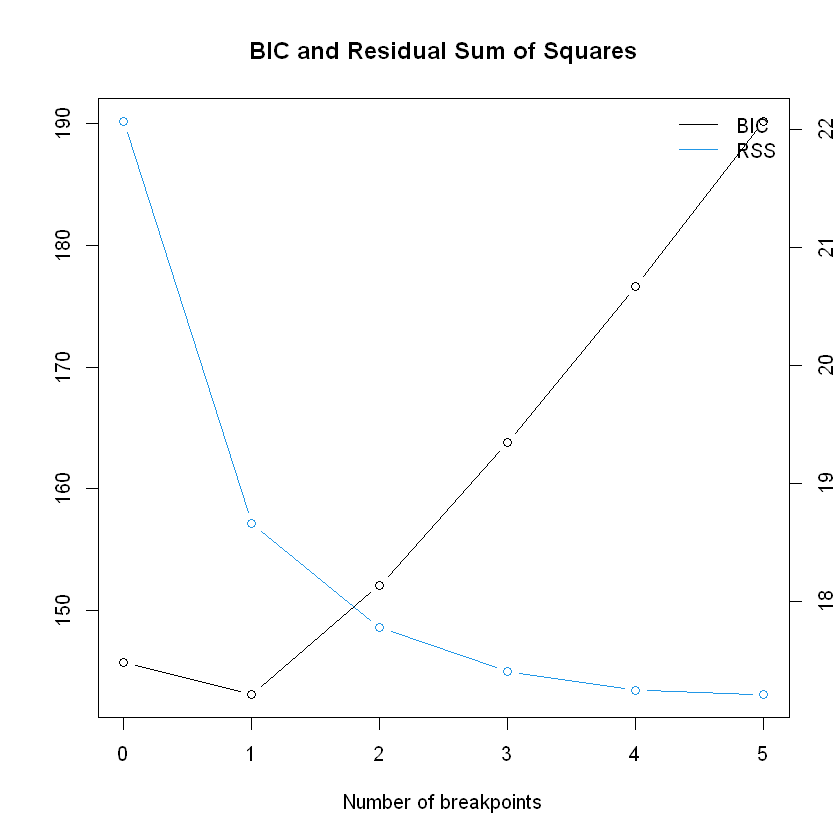

In [15]:
y <- ts_data[-1]

# 2. Create the independent variable 'x' (all values except the last)
# This is now the one-period lag of y
x <- ts_data[-length(ts_data)]

# Now 'y' and 'x' are perfectly aligned, and we can test for a break
# in the regression of y on x.
bp_test <- breakpoints(y ~ x)

# The rest is the same
summary(bp_test)
plot(bp_test)

In [16]:
break_observation <- cpi_quarterly_stationary[79, ]

print(break_observation)

# A tibble: 1 × 4
  quarter VALUE cpi_previous_quarter delta_cpi
    <dbl> <dbl>                <dbl>     <dbl>
1   2020.  137.                 137.     0.170


In [17]:
pre_break_data <- cpi_quarterly_stationary[1:79, ]
post_break_data <- cpi_quarterly_stationary[80:nrow(cpi_quarterly_stationary), ]

In [18]:
library(tseries)

# Test the pre-break period
adf.test(na.omit(pre_break_data$delta_cpi))

# Test the post-break period
adf.test(na.omit(post_break_data$delta_cpi))

Warning message in adf.test(na.omit(pre_break_data$delta_cpi)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  na.omit(pre_break_data$delta_cpi)
Dickey-Fuller = -4.4332, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  na.omit(post_break_data$delta_cpi)
Dickey-Fuller = -2.071, Lag order = 2, p-value = 0.5454
alternative hypothesis: stationary


In [19]:
install.packages("vars")
library(vars)

also installing the dependencies 'urca', 'lmtest'




package 'urca' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'vars' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\RtmpArMKgX\downloaded_packages


Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: urca

Loading required package: lmtest



In [20]:
lag_selection <- VARselect(cpi_quarterly_stationary, lag.max = 8, type = "const")

# Print the results
print(lag_selection$selection)

ERROR: Error in VARselect(cpi_quarterly_stationary, lag.max = 8, type = "const"): 
NAs in y.

